In [1]:
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import residual_GAN
from image_dataset import image_dataset
from torch.utils.data import RandomSampler
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
path_gen = r"resnet_300M_generator/"
path_disc = r"resnet_300M_discriminator/"
discriminator = residual_GAN.Discriminator().to(device)
discriminator.load_state_dict(torch.load(path_disc+"discriminator.pth"))
generator = residual_GAN.Generator(noise_dim=2048).to(device)
generator.load_state_dict(torch.load(path_gen+"generator.pth"))

<All keys matched successfully>

# Data Pipeline and Utility Functions

In [3]:
def noise_generator(device,batch_size=64, dimension=2048):
    return torch.randn((batch_size, dimension)).to(device)

In [4]:
img_transforms = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
folder = "../../Datasets/annotated_img/images/train2017"
train_dataset = image_dataset(folder,img_transforms)
batch_size = 64
num_samples = 32000
train_sampler = RandomSampler(train_dataset,replacement=False,num_samples=num_samples)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
print(len(train_dataloader))

500

# training routine

In [5]:
model_name = "resnet_300M"
if not os.path.exists(model_name):
    os.makedirs(model_name)

In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [7]:
def train_discriminator(discriminator, real_data, fake_data, loss_fn, optimizer,real_factor=4):
    optimizer.zero_grad()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real, torch.ones((len(real_data),1)).to(device))
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake, torch.zeros((len(fake_data),1)).to(device))
    loss = loss_real * real_factor + loss_fake
    loss.backward()
    optimizer.step()
    return loss_real, loss_fake

In [8]:
def discriminator_loop(train_dataloader,num_epochs,threshold,num_counts,
                       discriminator, loss_fn, optimizer,real_factor=4):
    N = len(train_dataloader)
    noise_dim=2048
    log = Report(num_epochs)
    loss_total=0
    num_batchs=0
    count=0

    for epoch in range(num_epochs):
        for idx, imgs in enumerate(train_dataloader):
            real_data = imgs.to(device)
            fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
            fake_data = fake_data.detach()
            loss_real, loss_fake = train_discriminator(discriminator,real_data,fake_data,loss_fn,optimizer,real_factor)
            total_loss = loss_real.item() + loss_fake.item()
            num_batchs += 1
            loss_total += total_loss
            log.record(epoch+(1+idx)/N, total_loss = total_loss, loss_real = loss_real.item(),
                    loss_fake = loss_fake.item(), end = '\r')
        log.report_avgs(epoch+1)
        if (loss_total/num_batchs) < threshold:
            count += 1
            if count == num_counts:
                torch.save(discriminator.state_dict(),model_name+"_discriminator"+"/discriminator.pth")
                break
        else:
            count = 0
        loss_total = 0
        num_batchs = 0

In [9]:
def train_generator(discriminator,fake_data,loss_fn,optimizer):
    optimizer.zero_grad()
    pred = discriminator(fake_data)
    loss = loss_fn(pred,torch.ones(len(fake_data),1).to(device))
    loss.backward()
    optimizer.step()
    return loss

In [10]:
def generator_loop(N,batch_size,num_epochs,threshold,num_counts,
                   discriminator,loss_fn,optimizer):
    noise_dim = 2048
    log = Report(num_epochs)
    loss_total = 0
    num_batchs = 0
    count = 0
    for epoch in range(num_epochs):
        for idx in range(N):
            fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
            loss = train_generator(discriminator, fake_data, loss_fn, optimizer)
            loss_total += loss.item()
            num_batchs += 1
            log.record(epoch+(1+idx)/N,g_loss = loss.item(), end='\r')
        log.report_avgs(epoch+1)
        if (loss_total/num_batchs) < threshold:
            count += 1
            if count == num_counts:
                torch.save(generator.state_dict(),model_name+"_generator"+"/generator.pth")
                break
        else:
            count = 0
        loss_total = 0
        num_batchs = 0

In [11]:
num_iterations = 10
noise_dim = 2048
d_epochs=3
g_epochs = 7
g_N = 500
g_batch_size = 64
g_threshold=0.1
d_threshold=0.06
g_counts = 1
d_counts = 1
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=9e-6)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=1e-5)


for n in range(num_iterations):
    print(f"\nTraining Discriminator - {n}")
    discriminator_loop(train_dataloader,d_epochs,d_threshold,d_counts,discriminator,loss_fn,d_optimizer)
    print(f"\nTraining Generator - {n}")
    generator_loop(g_N,g_batch_size,g_epochs,g_threshold,g_counts,
                   discriminator, loss_fn, g_optimizer)

torch.save(generator.state_dict(),model_name+"/generator.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")


Training Discriminator - 0

EPOCH: 0.692  total_loss: 0.066  loss_real: 0.043  loss_fake: 0.023  (194.58s - 648.99s remaining)

In [ ]:
num_iterations = 10
noise_dim = 2048
d_epochs=3
g_epochs = 7
g_N = 500
g_batch_size = 64
g_threshold=0.1
d_threshold=0.05
g_counts = 1
d_counts = 1
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=9e-6)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=1e-5)


for n in range(num_iterations):
    print(f"\nTraining Discriminator - {n}")
    discriminator_loop(train_dataloader,d_epochs,d_threshold,d_counts,discriminator,loss_fn,d_optimizer)
    print(f"\nTraining Generator - {n}")
    generator_loop(g_N,g_batch_size,g_epochs,g_threshold,g_counts,
                   discriminator, loss_fn, g_optimizer)

torch.save(generator.state_dict(),model_name+"/generator2.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator2.pth")


Training Discriminator - 0

EPOCH: 1.000  loss_fake: 0.234  total_loss: 0.290  loss_real: 0.056  (268.89s - 537.78s remaining)
EPOCH: 2.000  loss_fake: 0.042  total_loss: 0.052  loss_real: 0.010  (538.06s - 269.03s remaining)
EPOCH: 3.000  loss_fake: 0.026  total_loss: 0.032  loss_real: 0.007  (806.45s - 0.00s remaining)))


Training Generator - 0

EPOCH: 1.000  g_loss: 4.464  (145.47s - 727.34s remaining)
EPOCH: 2.000  g_loss: 1.408  (291.15s - 582.30s remaining)
EPOCH: 3.000  g_loss: 0.449  (436.72s - 436.72s remaining)
EPOCH: 4.000  g_loss: 0.190  (582.24s - 291.12s remaining)
EPOCH: 5.000  g_loss: 0.126  (728.13s - 145.63s remaining)
EPOCH: 6.000  g_loss: 0.068  (874.12s - 0.00s remaining)))


Training Discriminator - 1

EPOCH: 1.000  loss_fake: 0.333  total_loss: 0.394  loss_real: 0.061  (269.38s - 538.76s remaining)
EPOCH: 2.000  loss_fake: 0.044  total_loss: 0.056  loss_real: 0.012  (538.49s - 269.24s remaining)
EPOCH: 3.000  loss_fake: 0.024  total_loss: 0.031  loss_real: 0.006  (807.43s - 0.00s remaining)))


Training Generator - 1

EPOCH: 1.000  g_loss: 0.829  (145.65s - 728.27s remaining)
EPOCH: 2.000  g_loss: 0.053  (291.21s - 582.42s remaining)
EPOCH: 3.000  g_loss: 0.021  (436.71s - 436.71s remaining)


Training Discriminator - 2

EPOCH: 1.000  loss_fake: 0.190  total_loss: 0.225  loss_real: 0.035  (268.43s - 536.85s remaining)
EPOCH: 2.000  loss_fake: 0.041  total_loss: 0.050  loss_real: 0.009  (537.31s - 268.65s remaining)


Training Generator - 2

EPOCH: 1.000  g_loss: 0.757  (146.00s - 730.00s remaining)
EPOCH: 2.000  g_loss: 0.026  (292.03s - 584.06s remaining)
EPOCH: 3.000  g_loss: 0.012  (437.94s - 437.94s remaining)


Training Discriminator - 3

EPOCH: 1.000  loss_fake: 0.235  total_loss: 0.261  loss_real: 0.026  (268.71s - 537.42s remaining)
EPOCH: 2.000  loss_fake: 0.026  total_loss: 0.032  loss_real: 0.007  (537.29s - 268.65s remaining)


Training Generator - 3

EPOCH: 1.000  g_loss: 1.219  (145.58s - 727.90s remaining)
EPOCH: 2.000  g_loss: 0.139  (291.29s - 582.58s remaining)
EPOCH: 3.000  g_loss: 0.105  (436.87s - 436.87s remaining)
EPOCH: 4.000  g_loss: 0.062  (582.47s - 291.24s remaining)
EPOCH: 5.000  g_loss: 0.036  (728.22s - 145.64s remaining)


Training Discriminator - 4

EPOCH: 1.000  loss_fake: 0.317  total_loss: 0.379  loss_real: 0.061  (267.85s - 535.69s remaining)
EPOCH: 2.000  loss_fake: 0.043  total_loss: 0.054  loss_real: 0.012  (536.07s - 268.03s remaining)
EPOCH: 3.000  loss_fake: 0.018  total_loss: 0.023  loss_real: 0.005  (805.31s - 0.00s remaining)))


Training Generator - 4

EPOCH: 1.000  g_loss: 0.612  (145.61s - 728.03s remaining)
EPOCH: 2.000  g_loss: 0.045  (291.31s - 582.62s remaining)
EPOCH: 3.000  g_loss: 0.021  (436.86s - 436.86s remaining)


Training Discriminator - 5

EPOCH: 1.000  loss_fake: 0.215  total_loss: 0.246  loss_real: 0.030  (268.33s - 536.65s remaining)
EPOCH: 2.000  loss_fake: 0.022  total_loss: 0.028  loss_real: 0.006  (536.82s - 268.41s remaining)


Training Generator - 5

EPOCH: 1.000  g_loss: 2.966  (145.91s - 729.54s remaining)
EPOCH: 2.000  g_loss: 0.616  (292.07s - 584.14s remaining)
EPOCH: 3.000  g_loss: 0.251  (437.98s - 437.98s remaining)
EPOCH: 4.000  g_loss: 0.139  (583.86s - 291.93s remaining)
EPOCH: 5.000  g_loss: 0.066  (729.59s - 145.92s remaining)
EPOCH: 6.000  g_loss: 0.054  (875.15s - 0.00s remaining)))


Training Discriminator - 6

EPOCH: 1.000  loss_fake: 0.208  total_loss: 0.244  loss_real: 0.037  (268.29s - 536.58s remaining)
EPOCH: 2.000  loss_fake: 0.047  total_loss: 0.058  loss_real: 0.011  (538.35s - 269.17s remaining)
EPOCH: 3.000  loss_fake: 0.016  total_loss: 0.020  loss_real: 0.004  (810.60s - 0.00s remaining)))


Training Generator - 6

EPOCH: 1.000  g_loss: 1.387  (146.67s - 733.33s remaining)
EPOCH: 2.000  g_loss: 0.068  (295.94s - 591.89s remaining)
EPOCH: 3.000  g_loss: 0.020  (444.80s - 444.80s remaining)


Training Discriminator - 7

EPOCH: 1.000  loss_fake: 0.332  total_loss: 0.392  loss_real: 0.060  (271.61s - 543.22s remaining)
EPOCH: 2.000  loss_fake: 0.040  total_loss: 0.049  loss_real: 0.009  (544.08s - 272.04s remaining)


Training Generator - 7

EPOCH: 1.000  g_loss: 2.519  (148.18s - 740.91s remaining)
EPOCH: 2.000  g_loss: 0.290  (296.24s - 592.48s remaining)
EPOCH: 3.000  g_loss: 0.066  (444.61s - 444.61s remaining)
EPOCH: 4.000  g_loss: 0.039  (592.68s - 296.34s remaining)


Training Discriminator - 8

EPOCH: 1.000  loss_fake: 0.208  total_loss: 0.241  loss_real: 0.034  (271.14s - 542.28s remaining)
EPOCH: 2.000  loss_fake: 0.019  total_loss: 0.024  loss_real: 0.005  (543.51s - 271.75s remaining)


Training Generator - 8

EPOCH: 1.000  g_loss: 2.117  (148.44s - 742.18s remaining)
EPOCH: 2.000  g_loss: 0.235  (297.38s - 594.77s remaining)
EPOCH: 3.000  g_loss: 0.094  (445.99s - 445.99s remaining)
EPOCH: 4.000  g_loss: 0.043  (594.53s - 297.27s remaining)


Training Discriminator - 9

EPOCH: 1.000  loss_fake: 0.238  total_loss: 0.278  loss_real: 0.040  (272.56s - 545.13s remaining)
EPOCH: 2.000  loss_fake: 0.042  total_loss: 0.051  loss_real: 0.009  (545.86s - 272.93s remaining)
EPOCH: 3.000  loss_fake: 0.026  total_loss: 0.032  loss_real: 0.006  (818.21s - 0.00s remaining)))


Training Generator - 9

EPOCH: 1.000  g_loss: 1.935  (148.67s - 743.34s remaining)
EPOCH: 2.000  g_loss: 0.197  (297.30s - 594.61s remaining)
EPOCH: 3.000  g_loss: 0.086  (446.05s - 446.05s remaining)
EPOCH: 4.000  g_loss: 0.050  (594.29s - 297.14s remaining)


In [ ]:
num_iterations = 10
noise_dim = 2048
d_epochs=3
g_epochs = 7
g_N = 500
g_batch_size = 64
g_threshold=0.1
d_threshold=0.05
g_counts = 1
d_counts = 1
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=9e-6)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=1e-5)


for n in range(num_iterations):
    print(f"\nTraining Discriminator - {n}")
    discriminator_loop(train_dataloader,d_epochs,d_threshold,d_counts,discriminator,loss_fn,d_optimizer)
    print(f"\nTraining Generator - {n}")
    generator_loop(g_N,g_batch_size,g_epochs,g_threshold,g_counts,
                   discriminator, loss_fn, g_optimizer)

torch.save(generator.state_dict(),model_name+"/generator3.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator3.pth")


Training Discriminator - 0

EPOCH: 1.000  loss_fake: 0.354  total_loss: 0.414  loss_real: 0.060  (277.40s - 554.81s remaining)
EPOCH: 2.000  loss_fake: 0.042  total_loss: 0.053  loss_real: 0.010  (554.49s - 277.25s remaining)
EPOCH: 3.000  loss_fake: 0.021  total_loss: 0.025  loss_real: 0.005  (831.81s - 0.00s remaining)))


Training Generator - 0

EPOCH: 1.000  g_loss: 3.503  (150.48s - 752.41s remaining)
EPOCH: 2.000  g_loss: 0.968  (300.74s - 601.48s remaining)
EPOCH: 3.000  g_loss: 0.472  (451.36s - 451.36s remaining)
EPOCH: 4.000  g_loss: 0.276  (602.43s - 301.22s remaining)
EPOCH: 5.000  g_loss: 0.186  (752.90s - 150.58s remaining)
EPOCH: 6.000  g_loss: 0.123  (903.42s - 0.00s remaining)))


Training Discriminator - 1

EPOCH: 1.000  loss_fake: 0.290  total_loss: 0.341  loss_real: 0.051  (275.46s - 550.92s remaining)
EPOCH: 2.000  loss_fake: 0.045  total_loss: 0.054  loss_real: 0.009  (549.83s - 274.92s remaining)
EPOCH: 3.000  loss_fake: 0.026  total_loss: 0.032  loss_real: 0.006  (823.49s - 0.00s remaining)))


Training Generator - 1

EPOCH: 1.000  g_loss: 2.003  (148.92s - 744.62s remaining)
EPOCH: 2.000  g_loss: 0.204  (297.93s - 595.86s remaining)
EPOCH: 3.000  g_loss: 0.084  (446.92s - 446.92s remaining)
EPOCH: 4.000  g_loss: 0.052  (595.92s - 297.96s remaining)


Training Discriminator - 2

EPOCH: 1.000  loss_fake: 0.174  total_loss: 0.208  loss_real: 0.034  (273.54s - 547.08s remaining)
EPOCH: 2.000  loss_fake: 0.022  total_loss: 0.029  loss_real: 0.006  (547.27s - 273.64s remaining)


Training Generator - 2

EPOCH: 1.000  g_loss: 1.662  (149.45s - 747.27s remaining)
EPOCH: 2.000  g_loss: 0.376  (301.33s - 602.66s remaining)
EPOCH: 3.000  g_loss: 0.206  (456.22s - 456.22s remaining)
EPOCH: 4.000  g_loss: 0.149  (608.67s - 304.33s remaining)
EPOCH: 5.000  g_loss: 0.100  (761.83s - 152.37s remaining)
EPOCH: 6.000  g_loss: 0.065  (924.32s - 0.00s remaining)))


Training Discriminator - 3

EPOCH: 1.000  loss_fake: 0.275  total_loss: 0.327  loss_real: 0.052  (283.87s - 567.73s remaining)
EPOCH: 2.000  loss_fake: 0.057  total_loss: 0.069  loss_real: 0.012  (568.12s - 284.06s remaining)
EPOCH: 3.000  loss_fake: 0.036  total_loss: 0.044  loss_real: 0.008  (851.83s - 0.00s remaining)))


Training Generator - 3

EPOCH: 1.000  g_loss: 0.867  (162.33s - 811.67s remaining)
EPOCH: 2.000  g_loss: 0.023  (323.18s - 646.36s remaining)
EPOCH: 3.000  g_loss: 0.011  (485.16s - 485.16s remaining)


Training Discriminator - 4

EPOCH: 1.000  loss_fake: 0.209  total_loss: 0.231  loss_real: 0.021  (302.40s - 604.79s remaining)
EPOCH: 2.000  loss_fake: 0.013  total_loss: 0.017  loss_real: 0.003  (675.85s - 337.93s remaining)


Training Generator - 4

EPOCH: 1.000  g_loss: 1.646  (170.97s - 854.85s remaining)
EPOCH: 2.000  g_loss: 0.397  (363.60s - 727.20s remaining)
EPOCH: 3.000  g_loss: 0.235  (537.55s - 537.55s remaining)
EPOCH: 4.000  g_loss: 0.118  (737.93s - 368.97s remaining)
EPOCH: 5.000  g_loss: 0.089  (950.18s - 190.04s remaining)
EPOCH: 6.000  g_loss: 0.060  (1169.01s - 0.00s remaining)))


Training Discriminator - 5

EPOCH: 1.000  loss_fake: 0.209  total_loss: 0.248  loss_real: 0.039  (294.67s - 589.35s remaining)
EPOCH: 2.000  loss_fake: 0.032  total_loss: 0.039  loss_real: 0.008  (607.75s - 303.87s remaining)


Training Generator - 5

EPOCH: 1.000  g_loss: 1.987  (162.92s - 814.60s remaining)
EPOCH: 2.000  g_loss: 0.342  (334.74s - 669.49s remaining)
EPOCH: 3.000  g_loss: 0.143  (495.09s - 495.09s remaining)
EPOCH: 4.000  g_loss: 0.075  (655.64s - 327.82s remaining)
EPOCH: 5.000  g_loss: 0.070  (817.88s - 163.58s remaining)


Training Discriminator - 6

EPOCH: 1.000  loss_fake: 0.288  total_loss: 0.345  loss_real: 0.056  (286.15s - 572.30s remaining)
EPOCH: 2.000  loss_fake: 0.064  total_loss: 0.080  loss_real: 0.016  (575.92s - 287.96s remaining)
EPOCH: 3.000  loss_fake: 0.022  total_loss: 0.028  loss_real: 0.006  (861.95s - 0.00s remaining)))


Training Generator - 6

EPOCH: 1.000  g_loss: 1.746  (161.70s - 808.49s remaining)
EPOCH: 2.000  g_loss: 0.236  (323.33s - 646.65s remaining)
EPOCH: 3.000  g_loss: 0.128  (483.83s - 483.83s remaining)
EPOCH: 4.000  g_loss: 0.079  (644.97s - 322.49s remaining)
EPOCH: 5.000  g_loss: 0.060  (805.58s - 161.12s remaining)


Training Discriminator - 7

EPOCH: 1.000  loss_fake: 0.231  total_loss: 0.278  loss_real: 0.047  (286.06s - 572.12s remaining)
EPOCH: 2.000  loss_fake: 0.028  total_loss: 0.033  loss_real: 0.006  (571.30s - 285.65s remaining)


Training Generator - 7

EPOCH: 1.000  g_loss: 1.768  (161.68s - 808.39s remaining)
EPOCH: 2.000  g_loss: 0.573  (322.08s - 644.15s remaining)
EPOCH: 3.000  g_loss: 0.323  (483.19s - 483.19s remaining)
EPOCH: 4.000  g_loss: 0.182  (645.46s - 322.73s remaining)
EPOCH: 5.000  g_loss: 0.123  (807.77s - 161.55s remaining)
EPOCH: 6.000  g_loss: 0.077  (969.97s - 0.00s remaining)))


Training Discriminator - 8

EPOCH: 1.000  loss_fake: 0.422  total_loss: 0.495  loss_real: 0.073  (287.60s - 575.20s remaining)
EPOCH: 2.000  loss_fake: 0.067  total_loss: 0.084  loss_real: 0.017  (572.97s - 286.49s remaining)
EPOCH: 3.000  loss_fake: 0.042  total_loss: 0.051  loss_real: 0.009  (856.92s - 0.00s remaining)))


Training Generator - 8

EPOCH: 1.000  g_loss: 1.552  (162.29s - 811.45s remaining)
EPOCH: 2.000  g_loss: 0.360  (323.56s - 647.12s remaining)
EPOCH: 3.000  g_loss: 0.183  (485.68s - 485.68s remaining)
EPOCH: 4.000  g_loss: 0.099  (647.65s - 323.83s remaining)
EPOCH: 5.000  g_loss: 0.071  (809.40s - 161.88s remaining)


Training Discriminator - 9

EPOCH: 1.000  loss_fake: 0.306  total_loss: 0.357  loss_real: 0.052  (281.99s - 563.98s remaining)
EPOCH: 2.000  loss_fake: 0.073  total_loss: 0.094  loss_real: 0.021  (564.52s - 282.26s remaining)
EPOCH: 3.000  loss_fake: 0.034  total_loss: 0.042  loss_real: 0.009  (846.25s - 0.00s remaining)))


Training Generator - 9

EPOCH: 1.000  g_loss: 1.393  (163.68s - 818.38s remaining)
EPOCH: 2.000  g_loss: 0.234  (324.36s - 648.72s remaining)
EPOCH: 3.000  g_loss: 0.113  (484.70s - 484.70s remaining)
EPOCH: 4.000  g_loss: 0.099  (644.87s - 322.43s remaining)
EPOCH: 5.000  g_loss: 0.072  (805.68s - 161.14s remaining)


In [ ]:
num_iterations = 10
noise_dim = 2048
d_epochs=3
g_epochs = 7
g_N = 500
g_batch_size = 64
g_threshold=0.1
d_threshold=0.05
g_counts = 1
d_counts = 1
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=9e-6)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=1e-5)


for n in range(num_iterations):
    print(f"\nTraining Discriminator - {n}")
    discriminator_loop(train_dataloader,d_epochs,d_threshold,d_counts,discriminator,loss_fn,d_optimizer)
    print(f"\nTraining Generator - {n}")
    generator_loop(g_N,g_batch_size,g_epochs,g_threshold,g_counts,
                   discriminator, loss_fn, g_optimizer)

torch.save(generator.state_dict(),model_name+"/generator4.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator4.pth")


0.0042644403874874115

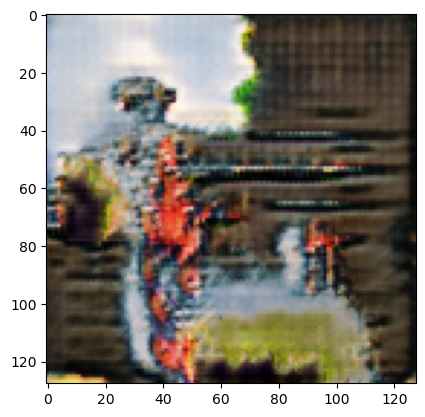

In [13]:
generator.to('cpu')
discriminator.to('cpu')
img = generator(noise_generator('cpu',1,2048))
p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img2 = img.detach().cpu().numpy()
img3 = img2.squeeze()
img3 = img3.transpose(1,2,0)
plt.imshow(img3)